In [ ]:
import pandas as pd
import numpy as np
import os
import torch, torchvision
import gc
import sklearn
import time
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as display
import glob
from skimage.io import imread 
from skimage.transform import resize 
from tqdm import tqdm_notebook 
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import shutil
from torchvision import models
from torch import optim
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time
import torch
import torchvision
import pickle
import numpy as np
from skimage import io
from tqdm.notebook import trange, tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

torch.manual_seed(17)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

In [ ]:
class ButterfliesDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files=None, labels=None, mode=None):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode
        self.labels = labels

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode in ['test', 'val']:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomVerticalFlip(p=0.5),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
          
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/drive/MyDrive/ColabNotebooks/butterflies/final_data/train')
TEST_DIR = Path('/content/drive/MyDrive/ColabNotebooks/butterflies/final_data/test')
VALID_DIR = Path('/content/drive/MyDrive/ColabNotebooks/butterflies/final_data/valid')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')), key=lambda x: int(x.name[:-4]))
train_labels = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/butterflies/final_data/train_labels.csv')
valid_files = sorted(list(VALID_DIR.rglob('*.jpg')), key=lambda x: int(x.name[:-4]))
valid_labels = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/butterflies/final_data/valid_labels.csv')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')), key=lambda x: int(x.name[:-4]))

In [ ]:
train_labels = [str(int(train_labels[train_labels['filenames'].apply(lambda x: x[6:]) == path.name]['label'].values)) for path in train_files]
valid_labels = [str(int(valid_labels[valid_labels['filenames'].apply(lambda x: x[6:]) == path.name]['label'].values)) for path in valid_files]

In [ ]:
train_dataset = ButterfliesDataset(train_files, train_labels, mode='train')
valid_dataset = ButterfliesDataset(valid_files, valid_labels, mode='val')
train_val_dataset = ButterfliesDataset(valid_files + train_files, valid_labels + train_labels, mode='train')

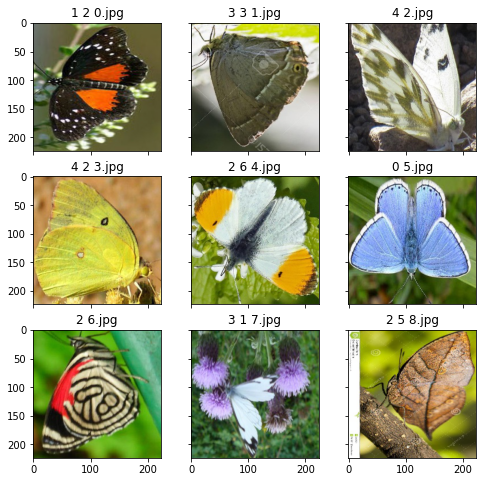

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    random_characters = i
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0])) + ' ' + train_files[random_characters].name
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in tqdm(train_loader):
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      preds = torch.argmax(outputs, 1)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_ds=None, val_ds=None, model=None, epochs=None, batch_size=None, unfreeze_idx=-1):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    history = []
    val_history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc: {t_acc:0.4f} val_loss: {v_loss:0.4f} val_acc: {v_acc:0.4f}"

    since = time.time()

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("train_loss", train_loss)
            
            history.append((train_loss, train_acc))

            if epoch == unfreeze_idx:
              for param in model.parameters():
                param.requires_grad = True
            
            with torch.no_grad():
              val_loss, val_acc = eval_epoch(model, val_loader, criterion)
              print("val_loss", val_loss)

            val_history.append((val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc, v_loss=val_loss, v_acc=val_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return history, val_history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
import torchvision.models as models

n_classes = len(np.unique(train_labels))
model = models.vgg16_bn(pretrained=True)
print("we will classify :{}".format(n_classes))

we will classify :50


In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5, inplace=False),
    nn.Linear(4096, 4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5, inplace=False),
    nn.Linear(4096, n_classes, bias=True)
)
model = model.to(DEVICE)
print(model)

In [ ]:
history, val_history = train(train_val_dataset, valid_dataset, model=model, epochs=5, batch_size=64, unfreeze_idx=4)

In [ ]:
t_loss, t_acc = zip(*history)
v_loss, v_acc = zip(*val_history)

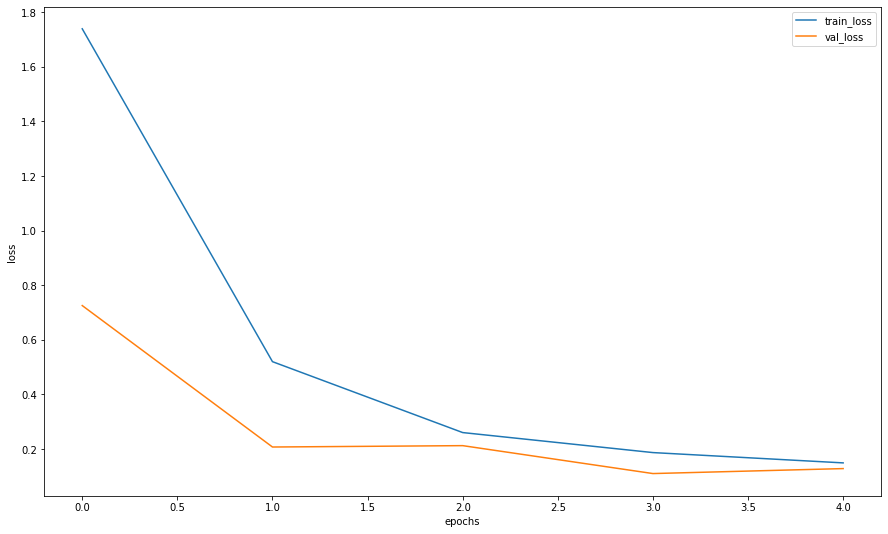

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(t_loss, label="train_loss")
plt.plot(v_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Submit

In [ ]:
test_dataset = ButterfliesDataset(test_files, mode='test')

In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
my_submit = pd.DataFrame(preds, columns=['y'])
my_submit.head()

,y
0,36
1,32
2,49
3,19
4,22


In [ ]:
my_submit.to_csv('efficientnet_b5_augment_train_val_5_epochs_4_unfreezeidx.csv', index=False)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

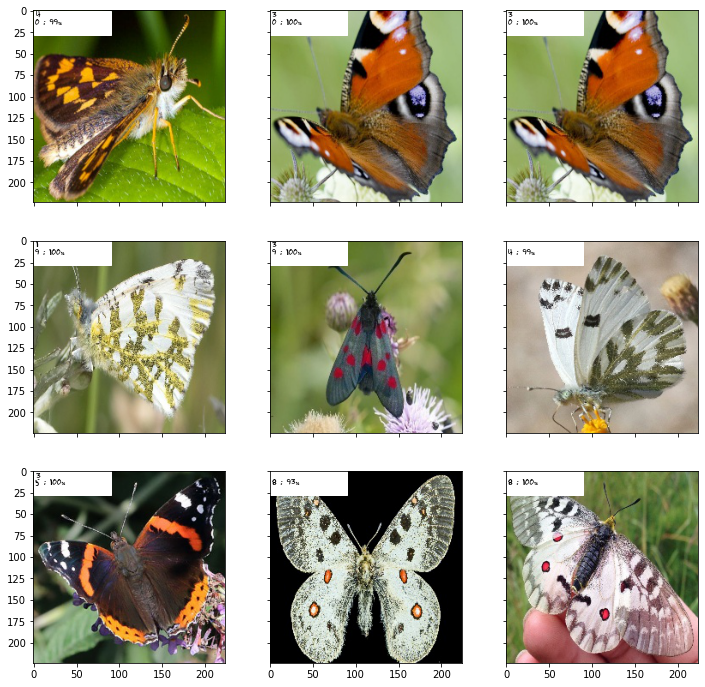

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val = test_dataset[random_characters]
    
    

    imshow(im_val.data.cpu(), plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 0),90,28,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(2, 0, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

#Размер выходного слоя нейронной сети

Дано, что размер входной карты признаков составляет B = 16 (размер батча), С = 3 (количество каналов), N = 100 (высота карты признаков), M = 200 (ширина карты признаков).
На схеме Conv2D — сверточные слои, MaxPool2D — слой подвыборки (пулинга), BatchNorm — слой батч-нормализации, ReLU — слой с соответствующей активационной функцией. На схеме также показаны значимые параметры соответствующих слоев. Смысл параметров такой же, как принято в библиотеке pytorch.

In [ ]:
x = torch.randn(16, 3, 100, 200)

Seq = nn.Sequential(
nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(5,5), stride=(1, 1), padding=(0, 0), dilation=(1, 1)), 
nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(4,3), stride=(2, 1), padding=(0, 0), dilation=(2, 2)),
nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1)),
nn.Conv2d(in_channels=30, out_channels=100, kernel_size=(1,1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
)

y = Seq(x)
y.shape

torch.Size([16, 100, 22, 96])